<a href="https://colab.research.google.com/github/ahmedhisham73/generative-modeling-using-tensorflow/blob/main/handsigngeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import numpy as np

import urllib.request
import zipfile
from IPython import display

In [4]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [8]:
!mkdir data

In [11]:
!unzip /content/drive/MyDrive/signs-training.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/signs-training/18213.png  
  inflating: /content/data/signs-training/21492.png  
  inflating: /content/data/signs-training/4779.png  
  inflating: /content/data/signs-training/10897.png  
  inflating: /content/data/signs-training/20954.png  
  inflating: /content/data/signs-training/3016.png  
  inflating: /content/data/signs-training/11551.png  
  inflating: /content/data/signs-training/12058.png  
  inflating: /content/data/signs-training/7270.png  
  inflating: /content/data/signs-training/15737.png  
  inflating: /content/data/signs-training/8143.png  
  inflating: /content/data/signs-training/23285.png  
  inflating: /content/data/signs-training/14429.png  
  inflating: /content/data/signs-training/13346.png  
  inflating: /content/data/signs-training/395.png  
  inflating: /content/data/signs-training/1601.png  
  inflating: /content/data/signs-training/13420.png  
  inflating: /content/data/signs-train

In [12]:
BATCH_SIZE = 32

# mapping function for preprocessing the image files
def map_images(file):
  '''converts the images to floats and normalizes the pixel values'''
  img = tf.io.decode_png(tf.io.read_file(file))
  img = tf.dtypes.cast(img, tf.float32)
  img = img / 255.0
  
  return img

# create training batches
filename_dataset = tf.data.Dataset.list_files("/content/data/signs-training/*.png")
image_dataset = filename_dataset.map(map_images).batch(BATCH_SIZE)

In [13]:
# You'll pass the random_normal_dimensions to the first dense layer of the generator
random_normal_dimensions = 32


generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[random_normal_dimensions]), 
    keras.layers.Reshape([7, 7, 128]), 
    keras.layers.BatchNormalization(), 
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),  
    keras.layers.BatchNormalization(), 

    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh") 
    
    
])

In [14]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
    
    
    
    
    
])

In [15]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False 

In [17]:
gan = keras.models.Sequential([generator, discriminator]) 
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [18]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            

            # infer batch size from the current batch of real images
            batch_size = real_images.shape[0]
            
            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True 
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)
            
            # Freeze the discriminator
            discriminator.trainable = False 

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels ) 

        plot_results(fake_images, 16)                     
        plt.show()
    return fake_images


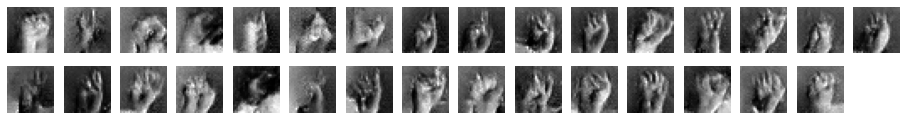

In [19]:
# you can adjust the number of epochs
EPOCHS = 10

# run the training loop and collect images
fake_images = train_gan(gan, image_dataset, random_normal_dimensions, EPOCHS)